In [2]:
import pandas as pd
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from openTSNE import TSNE

import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches

### Get data

In [29]:
df = pd.read_csv("data/topics_df.csv")
all_info = pd.read_csv("/home/sarah/projects/nets/data/wos_scopus_all.csv")
tech = pd.read_csv("/home/sarah/projects/nets_climatebert/data/2023-03-25_tech_predicted_unbalanced.csv")
allClasses = [i.split('pred_')[1] for i in tech.columns if 'pred_' in i]

def get_highest_prob(row):
    high_prob = 0
    cl = allClasses[0]    
    for c in allClasses:
        if row['predProba_'+c]>high_prob:
            high_prob = row['predProba_'+c]
            cl = c
    return cl

tech['first_pred_tech'] = tech.apply(get_highest_prob, axis=1)

df = df.merge(all_info[["id","title","abstract"]], how="left", on="id")
df = df.merge(tech[['id']+[i for i in tech.columns if 'pred_' in i]+[i for i in tech.columns if 'predProba_' in i]], how="left", on='id')

# no tech prediciton
df = df.dropna(subset="first_pred_tech")

In [30]:
df["num_tech"] = df[['pred_Forest Management',
 'pred_Other technologies',
 'pred_restoration of landscapes/peats',
 'pred_Algae farming',
 'pred_Blue Carbon',
 'pred_Agroforestry',
 'pred_AR',
 'pred_Biochar',
 'pred_CCUS',
 'pred_DAC(CS)',
 'pred_BECCS',
 'pred_Enhanced Weathering (land based)',
 'pred_Soil Carbon Sequestration',
 'pred_General Literature on CDR/NET',
 'pred_Ocean alkalinity enhancement',
 'pred_Ocean fertilization & Artificial upwelling']].apply(sum, axis=1)

In [31]:
# deduplicate

def make_tslug(s):
    if s is not None:
        return re.sub('\W','',s).lower()
    else:
        return None
    
df["tslug"] = df.title.apply(make_tslug)
print(df.shape)
print(df.drop_duplicates(subset="tslug").shape)

df = df.drop_duplicates(subset="tslug")
df["title_abstract"] = df["title"] + df["abstract"]

df = df.dropna(subset="title_abstract")
print(df.shape)

(23132, 170)
(22229, 170)
(22225, 171)


### Calculate tsne

In [32]:
vectorizer = TfidfVectorizer(stop_words='english') 
tfidf_text = vectorizer.fit_transform(df["title_abstract"])

In [33]:
pca = TruncatedSVD(n_components=50)
pca_result = pca.fit_transform(tfidf_text)
tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)
tsne_fit = tsne.fit(pca_result)

--------------------------------------------------------------------------------
TSNE(n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 3.50 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.33 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.13 seconds
===> Running optimization with exaggeration=12.00, lr=1852.08 for 250 iterations...
Iteration   50, KL divergence 5.5625, 50 iterations in 1.5796 sec
Iteration  100, KL divergence 5.3667, 50 iterations in 2.1410 sec
Iteration  150, KL divergence 5.3589, 50 iterations in 2.2071 sec
Iteration  200, KL divergence 5.3584, 50 iterations in 2.1733 sec
Iteration  250, KL divergence 5.3584, 50 iterations in 2.1190 sec
   --> Time elapsed: 10.22 seconds
===> Running optimization with exaggeration=1.00, lr=1852.08 for 50

In [34]:
df["tsne_x"] = list(tsne_fit[:,0])
df["tsne_y"] = list(tsne_fit[:,1])

df.to_csv("data/topics_tsne.csv", index=False)

In [35]:
tech_goodOrder = [
    "CCS",
    "BECCS",
    "DAC(CS)",
    "CCUS",
  
    "Soil Carbon Sequestration",
    "AR",
    "restoration of landscapes/peats",
    "Agroforestry",
    "Forest Management",
    
    "Biochar",
    
    "Enhanced Weathering (land based)",
    
    "Ocean alkalinity enhancement",
    "Blue Carbon",
    "Algae farming",
    "Ocean fertilization & Artificial upwelling",
    
    "General Literature on CDR/NET",
    "Other technologies",
]

col_ccs = ['#fdae6b','#fc8d59','#e6550d','#d7301f']# oranges
col_ccs.reverse() 

col_landbased = ['#edf8e9','#bae4b3','#74c476','#31a354','#006d2c'] # greens
col_landbased.reverse() 

col_biochar =  ['#f768a1'] # violet

col_ew_landbased =  ['#c994c7'] # bright violet
col_ocean = ['#f1eef6','#bdc9e1','#74a9cf','#0570b0'] # blues
col_gen_other = ['#636363', '#bdbdbd'] # greys

color_tech = (
             col_ccs + 
             col_landbased +  
             col_biochar + 
             col_ew_landbased + 
             col_ocean +
             col_gen_other
)

tc = {}
for i, tech in enumerate(tech_goodOrder):
    tc[tech]=color_tech[i]
df["tech_color"] = df.first_pred_tech.replace(tc)

### Scatterplot

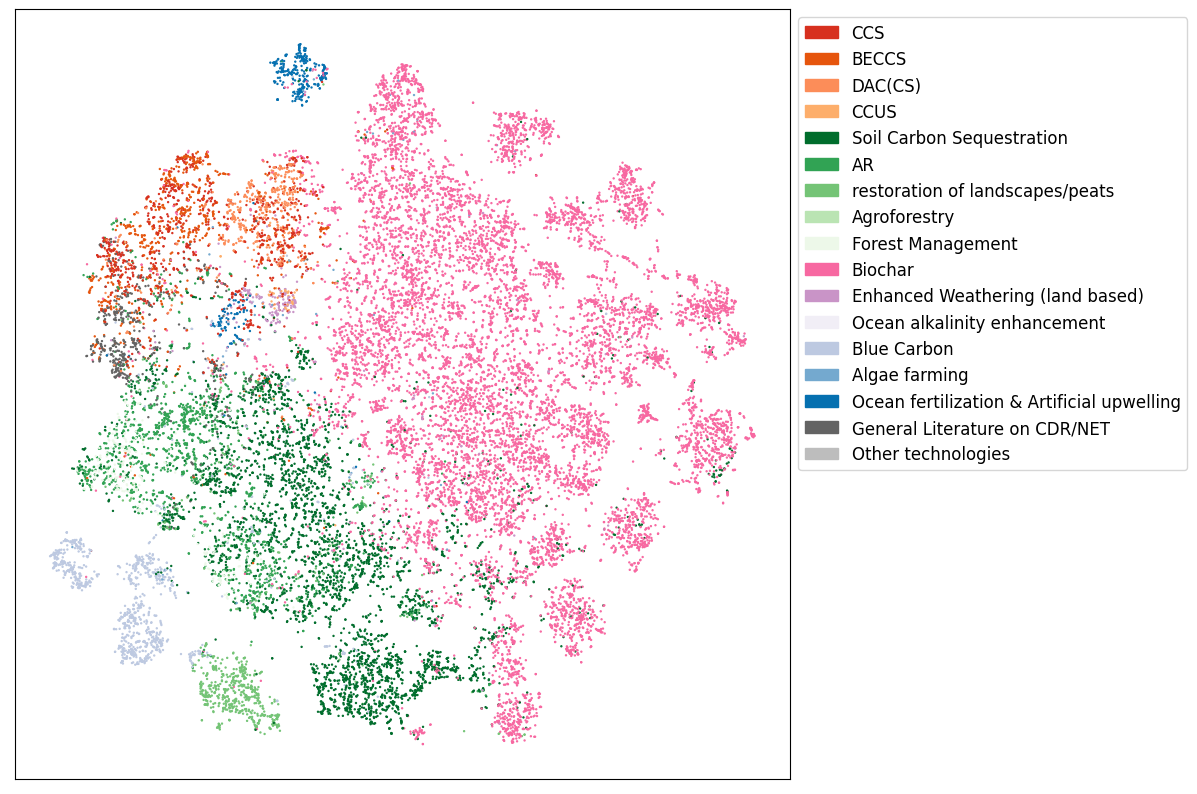

In [36]:
## complete with predicted tech
fig, ax = plt.subplots(figsize=(10,10))

#plt.axis('off')
ax.set_xticks([])
ax.set_yticks([])

_ = ax.scatter(df.tsne_x, df.tsne_y, s=0.5, c=df.tech_color)

legend_labels = []
for t in tech_goodOrder:
    legend_labels.append(mpatches.Patch(color=tc[t], label=t))
plt.legend(handles=legend_labels, bbox_to_anchor=(1,1), fontsize=12)
fig.savefig("figures/map_techs.png", bbox_inches="tight", facecolor='white', edgecolor='none')

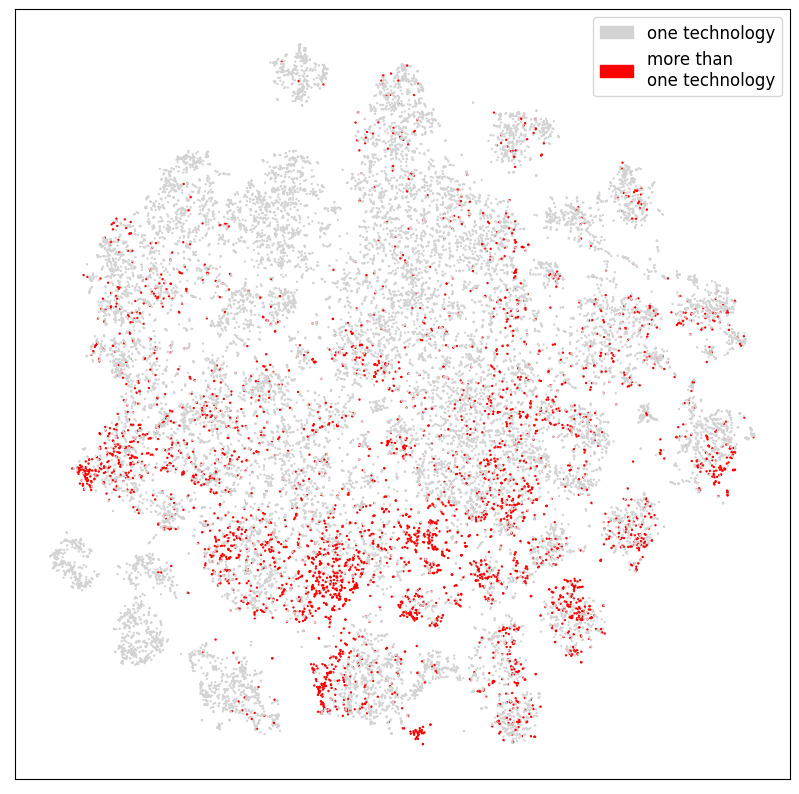

In [39]:
## complete with predicted tech
fig, ax = plt.subplots(figsize=(10,10))
df["double_col"] = "lightgrey"
df.loc[df["num_tech"]>1,"double_col"] = "red"


#plt.axis('off')
ax.set_xticks([])
ax.set_yticks([])

_ = ax.scatter(df.tsne_x, df.tsne_y, s=0.5, c=df.double_col)
legend_labels = []
legend_labels.append(mpatches.Patch(color='lightgrey', label='one technology'))
legend_labels.append(mpatches.Patch(color='red', label='more than \none technology'))
plt.legend(handles=legend_labels, bbox_to_anchor=(1,1), fontsize=12)
fig.savefig("figures/map_numTechs.png", bbox_inches="tight", facecolor='white', edgecolor='none')


### Scatterplot with topics

In [25]:
from adjustText import adjust_text, get_renderer, get_bboxes
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import mpld3
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull

import numpy as np

In [41]:
topics = pd.read_csv("data/topic_descriptions.csv")
all_topics = topics.topic_id.tolist()
topics_woBiochar = [t for t in all_topics if 'Biochar' not in t]
topics_Biochar = [t for t in all_topics if 'Biochar' in t]
topics_of = [t for t in all_topics if 'Ocean fertilization' in t]
topics_ccs = [t for t in all_topics if 'DAC(CS)' in t or 'BECCS' in t] 
topics_general = [t for t in all_topics if 'General' in t] 

df = df.reset_index()

In [42]:
def draw_one_topic(topic, min_samples_per_cluster, eps):
    title = topics.loc[topics.topic_id==topic, "short"].values[0]
    
    quant = df[topic].quantile(0.9)
    part_index = df.loc[df[topic]>=quant].index
    points_part = points[part_index] 
    db = DBSCAN(eps=eps, min_samples=min_samples_per_cluster).fit(points_part)
    
    # for each topic filter, cluster, circulate cluster
    for cluster in np.unique(db.labels_):
        if cluster==-1:
            continue
        points_cluster = points_part[np.where(db.labels_==cluster) ]
        try:
            hull = ConvexHull(points_cluster)
        except:
            continue
        cx = np.mean(hull.points[hull.vertices,0])
        cy = np.mean(hull.points[hull.vertices,1])
        c = [cx,cy]

        text = ax.annotate(
            title, c, fontsize=clabel_size,
            ha="center",va="center",
            bbox={'facecolor':"white", 'alpha':0.5, 'pad':0.2, 'boxstyle': 'round'}
        )
        texts.append(text)
        if drawHull:
            for simplex in hull.simplices:
                ax.plot(points_cluster[simplex, 0], points_cluster[simplex, 1], 'k--')

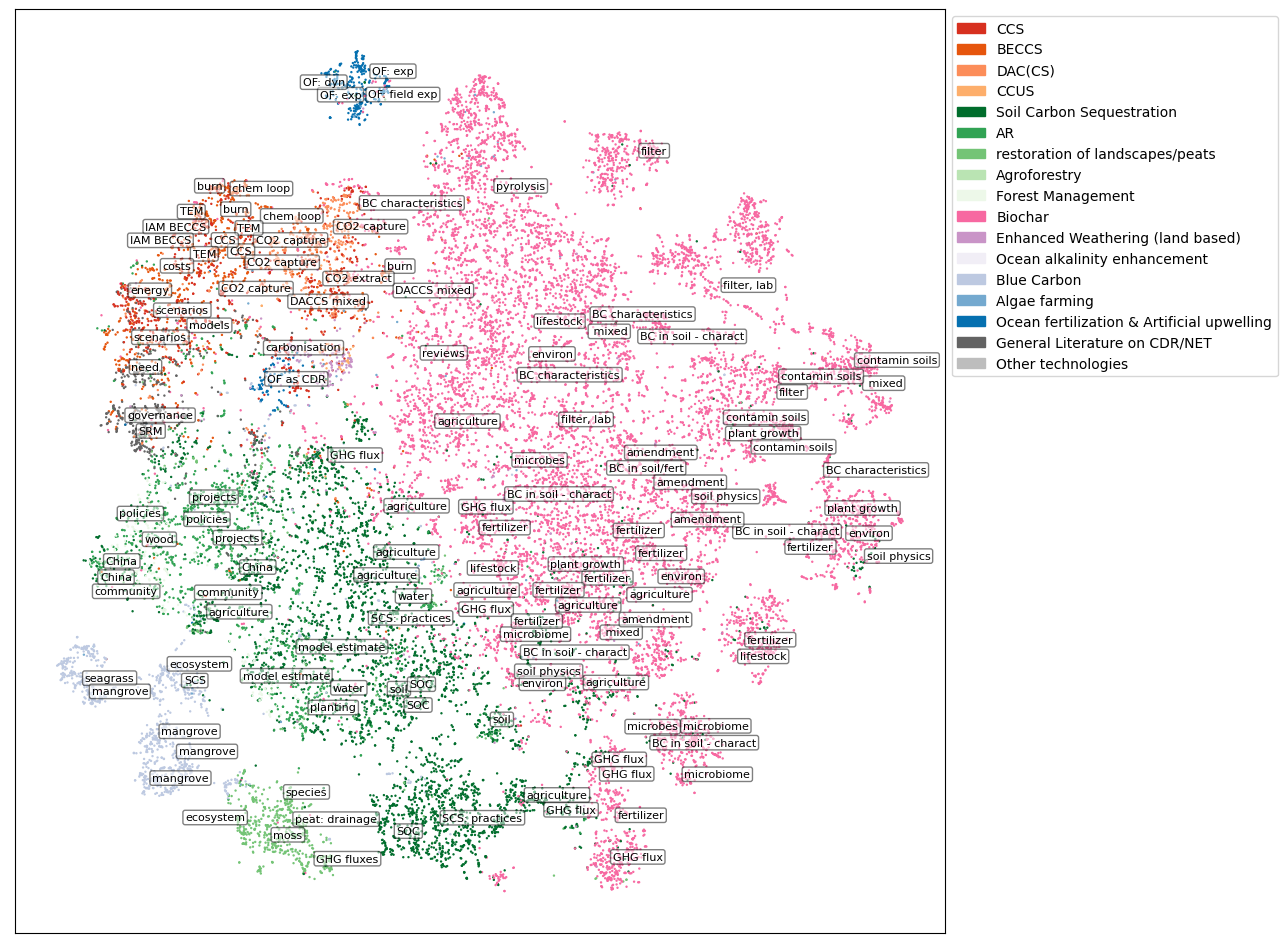

In [43]:
adjustText = True
drawHull = False

# get docs with highest score for each topic
fig, ax = plt.subplots(figsize=(12,12))
scatter = ax.scatter(df.tsne_x, df.tsne_y, s=0.5, c=df.tech_color)
clabel_size = 8

min_samples_per_cluster = 30

texts = []
points = np.array(df[["tsne_x","tsne_y"]])

for t in topics_Biochar:
    draw_one_topic(t,60, 8)
    
for t in topics_woBiochar:
    draw_one_topic(t,20,2)
    
for t in topics_of:
    draw_one_topic(t,15,4)

for t in topics_ccs:
    draw_one_topic(t,45,6)
        
if adjustText:
    adjust_text(texts,ax=ax, arrowprops=dict(arrowstyle="->", color='None', lw=0.5))

# legend
techs_con = df.first_pred_tech.unique().tolist()
#techs_goodOrder = [t for t in tech_goodOrder if t in techs_con]
legend_labels = []
for t in tech_goodOrder:
    legend_labels.append(mpatches.Patch(color=tc[t], label=t))
plt.legend(handles=legend_labels, bbox_to_anchor=(1,1))

ax.set_xticks([])
ax.set_yticks([])

# Make a quick interactive version and save that to html
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=list(df['title_abstract']))
mpld3.plugins.connect(fig, tooltip)
#with open(f'figure/nmf_{num_topics}.html','w') as f:
#    mpld3.save_html(fig,f)

# save figure
fig.savefig('figures/map_techs_topic.png', bbox_inches="tight", facecolor='white', edgecolor='none')

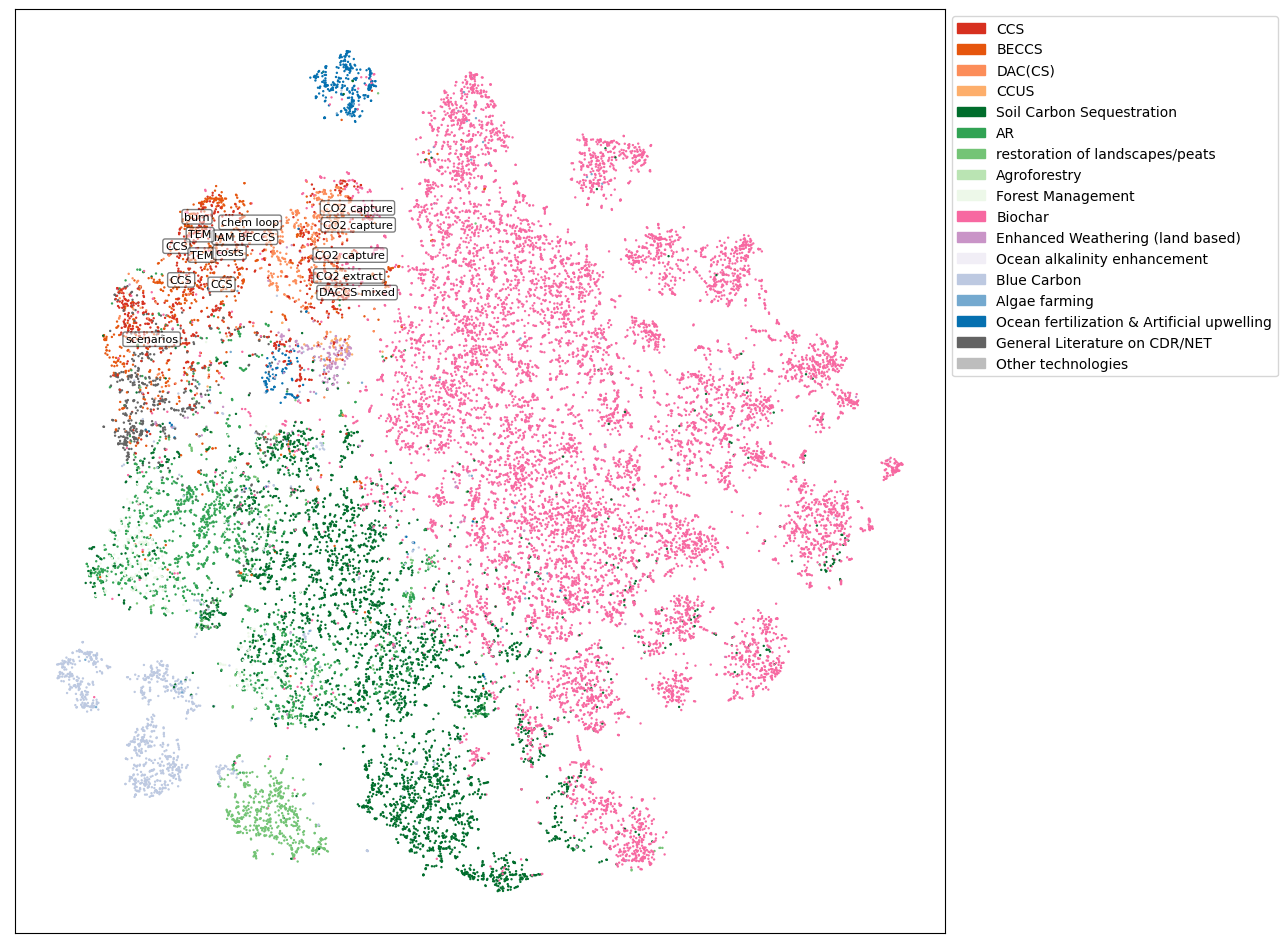

In [28]:
adjustText = True
drawHull = False

# get docs with highest score for each topic
fig, ax = plt.subplots(figsize=(12,12))
scatter = ax.scatter(df.tsne_x, df.tsne_y, s=0.5,c=df.tech_color)
clabel_size = 8

min_samples_per_cluster = 30

texts = []
points = np.array(df[["tsne_x","tsne_y"]])

#for t in topics_Biochar:
#    draw_one_topic(t,60, 8)
    
#for t in topics_woBiochar:
#    draw_one_topic(t,20,2)
#    
#for t in topics_of:
#    draw_one_topic(t,15,4)
#
for t in topics_ccs:
    draw_one_topic(t,45,6)
        
if adjustText:
    adjust_text(texts,ax=ax, arrowprops=dict(arrowstyle="->", color='None', lw=0.5))

# legend
techs_con = df.first_pred_tech.unique().tolist()
#techs_goodOrder = [t for t in tech_goodOrder if t in techs_con]
legend_labels = []
for t in tech_goodOrder:
    legend_labels.append(mpatches.Patch(color=tc[t], label=t))
plt.legend(handles=legend_labels, bbox_to_anchor=(1,1))

ax.set_xticks([])
ax.set_yticks([])

# Make a quick interactive version and save that to html
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=list(df['title_abstract']))
mpld3.plugins.connect(fig, tooltip)
#with open(f'figure/nmf_{num_topics}.html','w') as f:
#    mpld3.save_html(fig,f)

# save figure
#fig.savefig(f'figures/map_techs_topic.png', bbox_inches="tight", facecolor='white', edgecolor='none')